In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [2]:
Japan = pd.read_csv('Cleaned Data/Japan.csv')
China = pd.read_csv('Cleaned Data/China.csv')
Korea = pd.read_csv('Cleaned Data/Korea.csv')
Singapore = pd.read_csv('Cleaned Data/Singapore.CSV')
Malaysia = pd.read_csv('Cleaned Data/Malaysia.CSV')
Highincome  = pd.read_csv('Cleaned Data/Highincome_DF.CSV')
UpperMidincome = pd.read_csv('Cleaned Data/UpperMidincome_DF.CSV')
Japan.set_index('Year', inplace = True)
China.set_index('Year', inplace = True) 
Korea.set_index('Year', inplace = True)
Singapore.set_index('Year', inplace = True)
Malaysia.set_index('Year', inplace = True) 
Highincome.set_index('Year', inplace = True)
UpperMidincome.set_index('Year', inplace = True) 
Japan.dropna(inplace = True)
China.dropna(inplace = True)
Korea.dropna(inplace = True)
Singapore.dropna(inplace = True)
Singapore.dropna(inplace = True)
Malaysia.dropna(inplace = True)

In [3]:
def Test_Train_DF(x):
    quantile = x['GDP Growth'].quantile(.95)
    trimmedDF = x[x['GDP Growth'] < quantile]
    y_test = trimmedDF['GDP Growth'][50:-1]
    y_train = trimmedDF['GDP Growth'][:50]
    X_train =  trimmedDF.drop(columns = ['GDP Growth', 'GDP', 'GDP Per Capita', 'GDP Per Capita Growth'])[:50]
    X_test =  trimmedDF.drop(columns = ['GDP Growth', 'GDP', 'GDP Per Capita', 'GDP Per Capita Growth'])[50:]
    return (X_train, X_test, y_train, y_test)
def Test_Train_STD(x):
    std = x['GDP Growth'].std()
    mean = x['GDP Growth'].mean()
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    trimmedDF = x[(x['GDP Growth'] < upper) & (x['GDP Growth']> lower)]
    y_train =  trimmedDF['GDP Growth'][:50]
    y_test = trimmedDF['GDP Growth'][50:]
    X_train =  trimmedDF.drop(columns = ['GDP Growth', 'GDP', 'GDP Per Capita', 'GDP Per Capita Growth'])[:50]
    X_test =  trimmedDF.drop(columns = ['GDP Growth', 'GDP', 'GDP Per Capita', 'GDP Per Capita Growth'])[50:]
    return (X_train, X_test, y_train, y_test)
    return (X_train, X_test, y_train, y_test)

In [4]:
from sklearn.preprocessing import MinMaxScaler
def OLS_Reg(x):
    (X_train, X_test, y_train, y_test) = Test_Train_STD(x)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    result = sm.OLS(y_train, X_train).fit()
    return(result.summary())
print('Japan Summary:', OLS_Reg(Japan))
print('China Summary:', OLS_Reg(China))

Japan Summary:                                  OLS Regression Results                                
Dep. Variable:             GDP Growth   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              32.16
Date:                Fri, 08 Jul 2022   Prob (F-statistic):                    8.56e-14
Time:                        17:22:58   Log-Likelihood:                         -119.92
No. Observations:                  50   AIC:                                      249.8
Df Residuals:                      45   BIC:                                      259.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Based on this, x1, which is the fertility rate, seems to have bigger signficance for China. Moreover, having more number of younger population seem to have positive coefficent than aging population.

In [5]:
from sklearn.neighbors import KNeighborsRegressor
def KNNR_Accuracy(x):
        X_train, X_test, y_train, y_test = Test_Train_STD(x)
        knn = KNeighborsRegressor(n_neighbors =5, weights = 'distance')
        knn.fit(X_train, y_train)
        Accuracy_knn=knn.score(X_test,y_test)
        print(Accuracy_knn)
KNNR_Accuracy(Korea)

-2.235822150268167


summary:                               ARMA Model Results                              
Dep. Variable:             GDP Growth   No. Observations:                   50
Model:                     ARMA(1, 0)   Log Likelihood                -125.150
Method:                       css-mle   S.D. of innovations              2.938
Date:                Fri, 08 Jul 2022   AIC                            256.300
Time:                        17:22:58   BIC                            262.036
Sample:                             0   HQIC                           258.484
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.4208      1.257      3.516      0.000       1.957       6.885
ar.L1.GDP Growth     0.6807      0.107      6.376      0.000       0.471       0.890
                   

C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

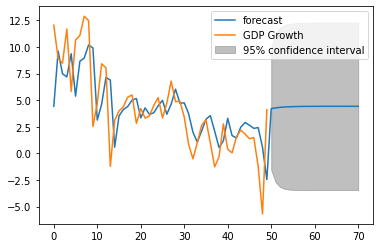

In [6]:
X_train, X_test, y_train, y_test = Test_Train_STD(Japan)
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(y_train, order=(1,0))
res = mod.fit()
print("summary:",res.summary())
res.plot_predict(start=0, end=70)
plt.show()

summary:                               ARMA Model Results                              
Dep. Variable:             GDP Growth   No. Observations:                   50
Model:                     ARMA(1, 0)   Log Likelihood                -151.493
Method:                       css-mle   S.D. of innovations              5.001
Date:                Fri, 08 Jul 2022   AIC                            308.986
Time:                        17:22:59   BIC                            314.722
Sample:                             0   HQIC                           311.171
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.9099      1.057      8.427      0.000       6.838      10.982
ar.L1.GDP Growth     0.3354      0.144      2.329      0.020       0.053       0.618
                   

C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sangr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

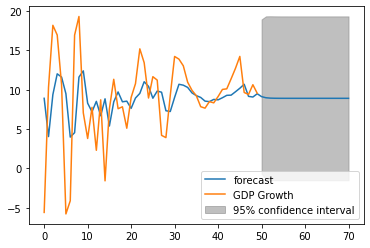

In [7]:
X_train, X_test, y_train, y_test = Test_Train_STD(China)
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(y_train, order=(1,0))
res = mod.fit()

print("summary:",res.summary())
res.plot_predict(start=0, end=70)
plt.show()

[ 0.          0.52538942  0.         -0.06822417  0.        ]


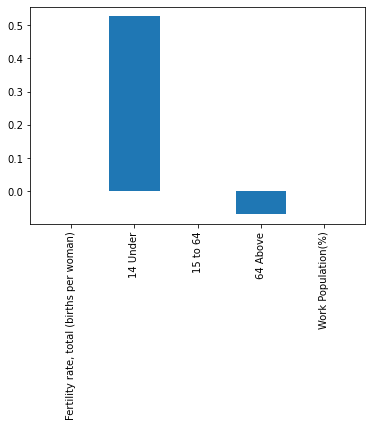

In [8]:
X_train, X_test, y_train, y_test = Test_Train_STD(Japan)
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.1)
lasso.fit(X_train, y_train)
# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)
plt.bar(X_train.columns, lasso_coef)
plt.xticks(rotation=90)
plt.show()

[ 0.42266998  0.          0.         -1.68709134 -0.27594188]


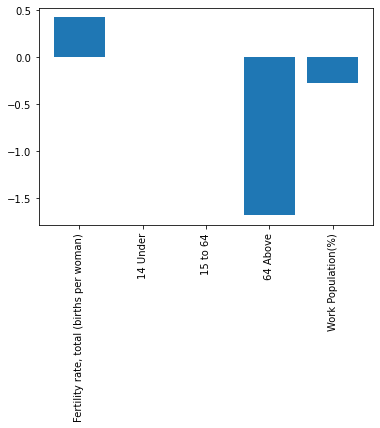

In [9]:
X_train, X_test, y_train, y_test = Test_Train_STD(China)
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.1)
lasso.fit(X_train, y_train)
# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)
plt.bar(X_train.columns, lasso_coef)
plt.xticks(rotation=90)
plt.show()

In [10]:
from sklearn.ensemble import RandomForestRegressor
def RandomForest_Accuracy(x):
    (X_train, X_test, y_train, y_test) = Test_Train_STD(x)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    regr = RandomForestRegressor(n_estimators = 100, random_state=42)
    regr.fit(X_train, y_train)
    prediction = regr.predict(X_test)
    return(regr.score(X_test, y_test))
print('Japan:',RandomForest_Accuracy(Japan))

Japan: -3.3667351659414617


In [11]:
from sklearn.ensemble import GradientBoostingRegressor
def Gradient_acc(x):
    X_train, X_test, y_train, y_test = Test_Train_STD(x)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg =GradientBoostingRegressor(random_state = 42)
    reg.fit(X_train, y_train)
    prediction = reg.predict(X_test)
    return(reg.score(X_test, y_test))
print('Japan:',Gradient_acc(Japan))
print('China:',Gradient_acc(China))

Japan: -4.3716151040711635
China: -1.163446067501321


In [18]:
from sklearn.neighbors import KNeighborsRegressor
def KNNR_Accuracy(x):
        X_train, X_test, y_train, y_test = Test_Train_STD(x)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        knn = KNeighborsRegressor(n_neighbors =3)
        knn.fit(X_train, y_train)
        Accuracy_knn=knn.score(X_test,y_test)
        print(Accuracy_knn)
KNNR_Accuracy(China)

-4.386012485153696


In [15]:
def Linear(x):
    X_train, X_test, y_train, y_test = Test_Train_STD(x)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg =LinearRegression()
    reg.fit(X_train, y_train)
    prediction = reg.predict(X_test)
    return(reg.score(X_train, y_train))
print('Japan:',Linear(Japan))
print('China:',Linear(China))

Japan: 0.5673510145436653
China: 0.14671113974817795


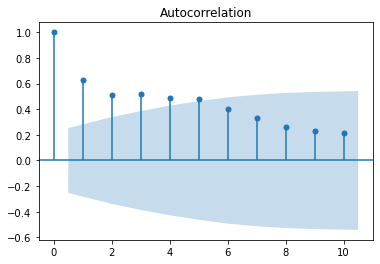

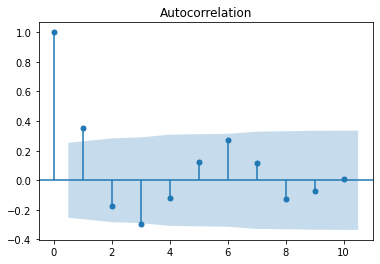

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Japan['GDP Growth'] ,lags=10)
plot_acf(China['GDP Growth'] ,lags=10)
plt.show()